# Publishing Figures - Land vs Aqua comparison
This obtains all figures for a combining all simulations of differing optical depth that only require the surface variables.

In [1]:
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import clausius_clapeyron_factor, sphum_sat, moist_static_energy
from isca_tools.utils.constants import L_v, c_p
from isca_tools.utils import area_weight_mean_lat, area_weighting
from isca_tools.utils.stats import z_score_from_confidence_interval
from isca_tools.thesis.adiabat_theory import get_scaling_factor_theory, get_gamma_factors, get_temp_adiabat
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.plot import label_subplots
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
import os
import numpy_indexed
from scipy.stats import median_abs_deviation
import matplotlib.transforms as mtransforms
from isca_tools.papers.miyawaki_2022 import get_dmse_dt, get_dvmse_dy, get_r1
from isca_tools.utils.radiation import frierson_atmospheric_heating
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

2024-07-22 19:40:34,401 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [2]:
# Load dataset
var_keep = ['temp', 'sphum', 'height']

# Don't include actual bucket, as looks very similar to bucket with vegetation param
exp_names = ['Aquaplanet', 'Land']
exp_dir = ['tau_sweep/aquaplanet/depth=1/',
           'tau_sweep/land/meridional_band/depth=1/bucket_evap/']
# exp_names = ['Aquaplanet', 'Bucket']
# exp_dir = ['tau_sweep/aquaplanet/depth=1/',
#            'tau_sweep/land/meridional_band/depth=1/bucket_evap/']
color_seq_exp = ['b', 'r']
pressure_ft = 500               # Desired approximate pressure of free troposphere (hPa)

tau_lw_ref = 1
tau_lw_warm = 1.5
kappa_names = [f"k={str(tau_lw_ref).replace('.','_')}", f"k={str(tau_lw_warm).replace('.','_')}"]
kappa_names.sort()
# kappa_names = kappa_names[2:-1]     # get rid of coldest 2 and warmest simulation as don't work well
n_exp = len(exp_names)
n_kappa = len(kappa_names)
ds = [[] for i in range(n_exp)]
albedo = []
tau_sw = []
tau_lw = []
with tqdm(total=n_exp * n_kappa, position=0, leave=True) as pbar:
    for i in range(n_exp):
        for j in range(n_kappa):
            ds_use = isca_tools.load_dataset(exp_dir[i] + kappa_names[j])[var_keep]
            ds[i] += [ds_use.sel(pfull=[np.inf, pressure_ft], method='nearest')]      # only keep the surface values
            namelist = isca_tools.load_namelist(exp_dir[i] + kappa_names[j])  # Need this for albedo_value
            if i == 0:
                albedo += [namelist['mixed_layer_nml']['albedo_value']]
                tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
                tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
            pbar.update(1)
tau_lw = np.asarray(tau_lw)
ind_surf = 0
ind_ft = 1
p_surface = float(ds[0][0].pfull[ind_surf]) * 100
pressure_ft_actual = float(ds[0][0].pfull[ind_ft]) * 100
n_pressure = 2

100%|██████████| 4/4 [00:06<00:00,  1.56s/it]


## Get datasets
Get one dataset for each $\kappa$, combining the desired latitudes: `ds_all`. This combines all or just the summer months in each hemisphere, e.g. negative latitudes will only correspond to times in December, January or February.

In [3]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

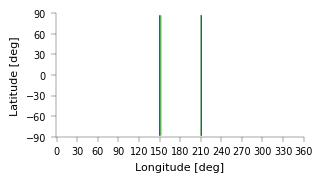

In [4]:
# Show where the land is
save_land_fig = False

job_dir = os.path.join(os.path.dirname(os.environ['GFDL_DATA']), 'jobs')
land_file_name = os.path.join(job_dir, exp_dir[1], kappa_names[0], 'land.nc')
# isca_tools.plot.show_land(land_file_name)
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
isca_tools.plot.show_land(land_file_name, fig=fig, ax=ax)
lon_land = isca_tools.utils.land.get_land_coords(land_file=land_file_name)[1]       # get the longitude coordinates of land

if save_fig or save_land_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/land_coords.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

In [5]:
# Load in across all latitudes, for given season
use_time_start = 360*2

# Chose whether to only consider summer days or consider all days
# season = 'all'
season = 'summer'   # NOTE - if summer, does not give many days corresponding to high percentiles as only 5 years of data used

# Select region to combine latitudes over for all but one of the plots below
# Tropics
region = 'tropics'
lat_min = 0
lat_max = 20

if season == 'summer':
    if region == 'tropics':
        season_months = {'nh': [5, 6, 7, 8, 9, 10], 'sh': [11, 12, 1, 2, 3, 4]}
    else:
        season_months = {'nh': [6, 7, 8], 'sh': [12, 1, 2]}   # JJA for NH and DJF for SH
elif season == 'winter':
    if region == 'tropics':
        season_months = {'sh': [5, 6, 7, 8, 9, 10], 'nh': [11, 12, 1, 2, 3, 4]}
    else:
        season_months = {'sh': [6, 7, 8], 'nh': [12, 1, 2]}

av_region = 'land'
# av_region = 'all'
av_method = 'median'    # take averaged conditioned on all days with surf temp equal 50th percentile - avoids issues with sphum_mean vs r_mean
# av_method = 'mean'
quant_median = 50

lat_use_ind = np.where((np.abs(ds[0][0].lat) <= lat_max) & (np.abs(ds[0][0].lat) >= lat_min))[0]
n_lat = len(lat_use_ind)
lat_weights = np.cos(np.deg2rad(ds[0][0].lat))[lat_use_ind]

ds_all = [[] for i in range(n_exp)]                             # ds_all is n_exp x n_kappa
ds_av = [[[] for j in range(n_kappa)] for i in range(n_exp)]    # ds_av is n_exp x n_kappa x n_lat
with tqdm(total=n_exp * n_kappa, position=0, leave=True) as pbar:
    for i in range(n_exp):
        for j in range(n_kappa):
            ds_use = ds[i][j].sel(time=slice(use_time_start, np.inf))
            ds_use = ds_use.isel(lat=lat_use_ind)   # only keep latitudes being used to save memory
            
            if av_region == 'all':
                if av_method == 'mean':
                    ds_av_use = ds_use.mean(dim=['lon', 'time']).load()
                    ds_av[i][j] = [ds_av_use.isel(lat=k) for k in range(n_lat)]
                elif av_method == 'median':
                    ds_av_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1)).load()
                    for k in range(n_lat):
                        use_ind = get_quant_ind(ds_av_use.temp.isel(pfull=ind_surf, lat=k), quant_median, 0.5, 0.5)
                        ds_av[i][j] += [ds_av_use.isel(lat=k).isel(lon_time=use_ind).mean(dim='lon_time')]
            
            if 'aqua' not in exp_names[i].lower():
                # if not aquaplanet, then is land and only consider land longitudes
                ds_use = ds_use.isel(lon=np.where(np.isin(ds_use.lon, np.unique(lon_land)))[0])
    
            if season == 'summer':
                ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, season_months['nh']).sel(lat=slice(0, 90))
                ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, season_months['sh']).sel(lat=slice(-90, 0))
                # Combine hemispheres and average over longitude, time and latitude.
                ds_use = xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')
            ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1)).load()
            ds_all[i] += [ds_use]
            if av_region == 'land':
                # Only take mean over land coordinates for land simulations
                # For aquaplanet, av_region is irrelevant.
                if av_method == 'mean':
                    ds_av_use = ds_use.mean(dim='lon_time')
                    ds_av[i][j] = [ds_av_use.isel(lat=k) for k in range(n_lat)]
                elif av_method == 'median':
                    for k in range(n_lat):
                        use_ind = get_quant_ind(ds_use.temp.isel(pfull=ind_surf, lat=k), quant_median, 0.5, 0.5)
                        ds_av[i][j] += [ds_use.isel(lat=k).isel(lon_time=use_ind).mean(dim='lon_time')]
            elif av_region != 'all':
                raise ValueError(f'Mean method is {av_region} which is not valid.')
            pbar.update(1)

100%|██████████| 4/4 [00:43<00:00, 10.80s/it]


## Near Surface Temperature Quantile
Plot quantile of near surface air temperature vs global average near surface air temperature for a given latitude band.

Near surface air temperature is the temperature at the lowest pressure level.

Here, we compute the quantile at each latitude coordinate across all longitudes and time and then average over these.

We average over all times after 2 years because, from the spin up plot above, after 2 years, the simulation has converged into a regular pattern, with a net TOA flux centered on 0.

In [17]:
# Need to choose quantile method, use 'temp' for comparison with land.
percentile_label = 'Temperature percentile, $x$'

# Get all data needed to compute theoretical temp change and to plot actual temp change for each quantile of temperature
quantiles_all = np.arange(1, 100)   # avoid 0 quantile as it gives weird results
n_quant_all = len(quantiles_all)     

temp_av = np.zeros((n_exp, n_kappa, n_pressure, n_lat))
z_av = np.zeros((n_exp, n_kappa, n_pressure, n_lat))
sphum_av = np.zeros((n_exp, n_kappa, n_lat))
temp_adiabat_av = np.zeros((n_exp, n_kappa, n_lat))

# quant3 is the actual quantile value rather than the average above a given quantile
temp_quant3 = np.zeros((n_exp, n_kappa, n_pressure, n_lat, n_quant_all))
z_quant3 = np.zeros((n_exp, n_kappa, n_pressure, n_lat, n_quant_all))
# specific humidity as function of specific humidity quantile not temp quantile
sphum_quant3 = np.zeros((n_exp, n_kappa, n_lat, n_quant_all))
# mse as function of mse quantile not temp quantile

with tqdm(total=n_exp*n_kappa*n_quant_all*n_lat, position=0, leave=True) as pbar:
    for i in range(n_exp):
        for j in range(n_kappa):
            ds_use = ds_all[i][j]
            # temp_quant3[i, j] = ds_use.temp.quantile(quantiles_all/100, dim='lon_time', keep_attrs=True).transpose()
            for k in range(n_lat):
                temp_av[i, j, :, k] = ds_av[i][j][k].temp
                z_av[i, j, :, k] = ds_av[i][j][k].height
                sphum_av[i, j, k] = ds_av[i][j][k].sphum.isel(pfull=ind_surf)
                temp_adiabat_av[i, j, k] = get_temp_adiabat(temp_av[i, j, ind_surf, k], sphum_av[i, j, k], p_surface, pressure_ft_actual)
                for q, quant in enumerate(quantiles_all):
                    use_ind = get_quant_ind(ds_use.temp[ind_surf, k], quant, 0.5, 0.5)
                    temp_quant3[i, j, :, k, q] = ds_use.temp[:, k, use_ind].mean(dim='lon_time')
                    z_quant3[i, j, :, k, q] = ds_use.height[:, k, use_ind].mean(dim='lon_time')
                    sphum_quant3[i, j, k, q] = ds_use.sphum[ind_surf, k, use_ind].mean(dim='lon_time')
                    pbar.update(1)
r_av = sphum_av / sphum_sat(temp_av[:, :, ind_surf], p_surface)
r_quant3 = sphum_quant3 / sphum_sat(temp_quant3[:, :, ind_surf], p_surface)
r_anom = r_quant3 - r_av[:, :, :, np.newaxis]

100%|██████████| 5544/5544 [00:24<00:00, 227.60it/s]


## Breakdown of difference in Dry get Hotter between aquaplanet and land
The scaling factor contribution to the dry get hotter mechanism is $-\frac{\gamma_r}{\overline{r_s}}\Delta r_s(x)$. We can split the difference in this between aquaplanet and land into three terms:

$\left(-\frac{\gamma_r}{\overline{r_s}}\Delta r_s(x)\right)\bigg|_{land-aqua} = -\Delta r_{s,aqua}(x)\left(\frac{\gamma_r}{\overline{r_s}}\right)\bigg|_{land-aqua} - \frac{\gamma_{r, aqua}}{\overline{r_{s, aqua}}} \Delta r_s(x) |_{land - aqua} - \left(\frac{\gamma_r}{\overline{r_s}}\right)\bigg|_{land-aqua} \Delta r_s(x) |_{land - aqua}$

The first is the sensitivity difference, the second is the anomaly difference and the third is the non-linear term.

In [40]:
gamma_r = np.zeros((n_exp, n_kappa, n_lat))
sf_r0_cont = np.zeros((n_exp, n_lat, n_quant_all))
for i in range(n_exp):
    for k in range(n_lat):
        for j in range(n_kappa):
            gamma_r[i, j, k] = get_gamma_factors(temp_av[i, j, ind_surf, k], sphum_av[i, j, k], temp_adiabat_av[i, j, k], 
                                                 p_surface, pressure_ft_actual)['t_mean_change']['r0']
        sf_r0_cont[i, k] = get_scaling_factor_theory(temp_av[i, :, ind_surf, k], temp_quant3[i, :, ind_surf, k], 
                                                      sphum_av[i, :, k], sphum_quant3[i, :, k], p_surface, pressure_ft_actual,
                                                      temp_av[i, :, ind_ft, k], temp_quant3[i, :, ind_ft, k], 
                                                      z_av[i, :, ind_ft, k], z_quant3[i, :, ind_ft, k],
                                                      non_linear=False, use_temp_adiabat=True, 
                                                      strict_conv_eqb=True, 
                                                      simple=True)[3]['t_mean_change']['r0']

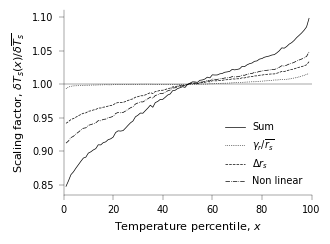

In [65]:
gamma_cont = -(gamma_r[1, 0]/r_av[1,0] - gamma_r[0, 0]/r_av[0,0])[:, np.newaxis] * r_anom[0, 0]
r_anom_cont = -(gamma_r[0, 0]/r_av[0,0])[:, np.newaxis] * (r_anom[1, 0] - r_anom[0, 0])
non_linear_cont = -(gamma_r[1, 0]/r_av[1,0] - gamma_r[0, 0]/r_av[0,0])[:, np.newaxis] * (r_anom[1, 0] - r_anom[0, 0])

save_dry_hotter_diff_fig = False
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
ax.plot(quantiles_all, 1+np.average(sf_r0_cont[1]-sf_r0_cont[0], axis=0, weights=lat_weights), color='k', label='Sum')
ax.plot(quantiles_all, 1+np.average(gamma_cont, axis=0, weights=lat_weights), color='k', linestyle=':', label='$\gamma_r/\overline{r_s}$')
ax.plot(quantiles_all, 1+np.average(r_anom_cont, axis=0, weights=lat_weights), color='k', linestyle='--', label='$\Delta r_s$')
ax.plot(quantiles_all, 1+np.average(non_linear_cont, axis=0, weights=lat_weights), color='k', linestyle='-.', label='Non linear')
# plt.plot(quantiles_all, np.average(non_linear_cont+r_anom_cont+gamma_cont, axis=0, weights=lat_weights))   # sanity check

ax.axhline(1, color='k', lw=ax_linewidth)
ax.set_ylabel('Scaling factor, $\delta T_s(x)/\delta \overline{T_s}$')
ax.set_xlabel(percentile_label)
ax.set_xlim(0, 100)
ax.legend()

if save_fig or save_dry_hotter_diff_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/dry_hotter_diff.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)